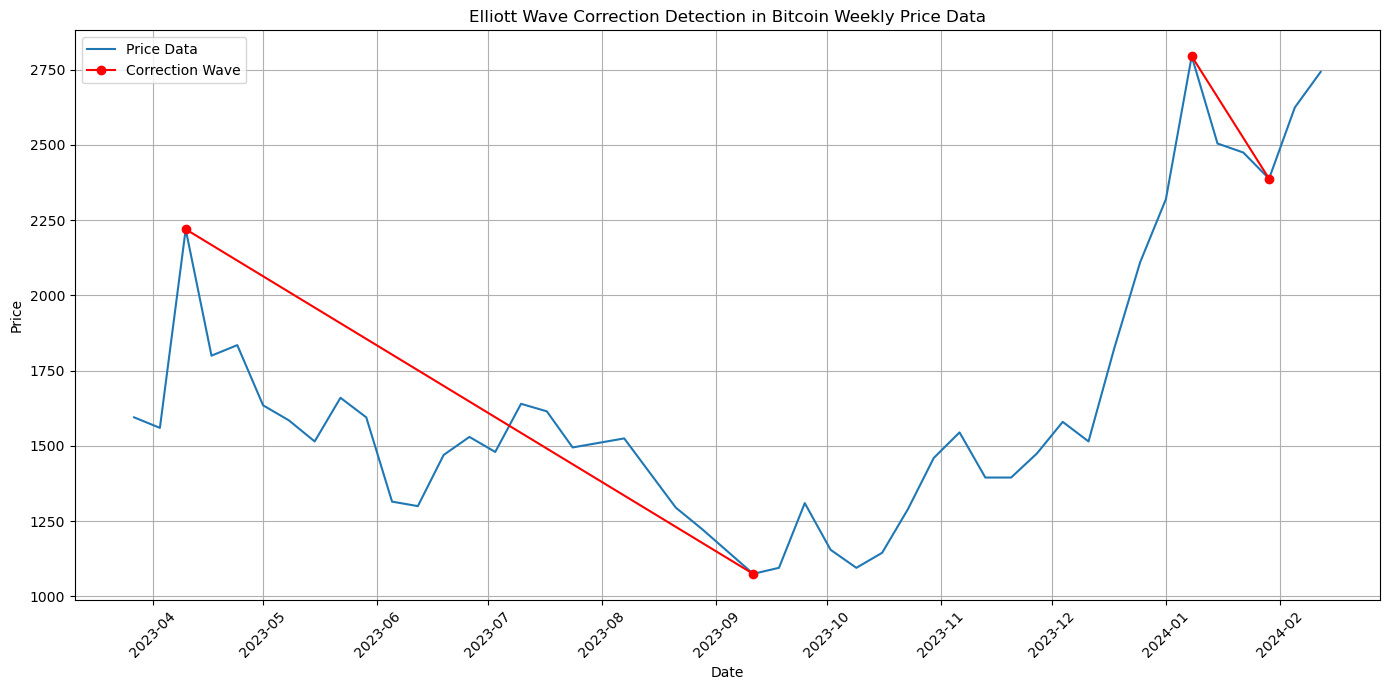

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def fetch_upbit_weekly_data(market_code='KRW-ARB', count=200):
    """
    Fetches weekly trading data from Upbit for a specified market.
    """
    url = "https://api.upbit.com/v1/candles/weeks"
    params = {"market": market_code, "count": str(count)}
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if not data:
            raise ValueError("No data returned from API")
        df = pd.DataFrame(data)
        if 'candle_date_time_utc' not in df.columns:
            raise ValueError("Expected data format not returned")
        df['timestamp'] = pd.to_datetime(df['candle_date_time_utc']).dt.date
        df = df[['timestamp', 'opening_price', 'high_price', 'low_price', 'trade_price']].copy()
        df.columns = ['Date', 'Open', 'High', 'Low', 'Close']
        df.set_index('Date', inplace=True)
        return df.sort_index()
    except requests.RequestException as e:
        print(f"API request error: {e}")
    except ValueError as e:
        print(f"Data processing error: {e}")
    return pd.DataFrame()

def find_peaks_and_troughs(price_data, distance=20, prominence=0.05):
    """
    Identifies the peaks and troughs in the provided price data.
    """
    peaks, _ = find_peaks(price_data, distance=distance, prominence=prominence)
    troughs, _ = find_peaks(-price_data, distance=distance, prominence=prominence)
    return peaks, troughs

def identify_correction_waves(price_data, peaks, troughs):
    """
    Identifies correction waves based on peaks and troughs.
    """
    correction_waves = []
    indices = np.array(range(len(price_data)))
    for peak in peaks:
        next_troughs = troughs[troughs > peak]
        if len(next_troughs) > 0:
            start = peak
            end = next_troughs[0]
            correction_waves.append((start, end))
    return correction_waves

def plot_correction_waves(price_data, correction_waves):
    """
    Plots the price data along with identified correction waves.
    """
    plt.figure(figsize=(14, 7))
    plt.plot(price_data.index, price_data, label='Price Data')
    for start, end in correction_waves:
        plt.plot(price_data.index[[start, end]], price_data.iloc[[start, end]], 'ro-', label='Correction Wave' if start == correction_waves[0][0] else "")
    plt.legend()
    plt.title('Elliott Wave Correction Detection in Bitcoin Weekly Price Data')
    plt.xticks(rotation=45)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.tight_layout()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    btc_weekly_data = fetch_upbit_weekly_data()
    if not btc_weekly_data.empty:
        preprocessed_data = btc_weekly_data['Close']
        peaks, troughs = find_peaks_and_troughs(preprocessed_data)
        correction_waves = identify_correction_waves(preprocessed_data, peaks, troughs)
        plot_correction_waves(preprocessed_data, correction_waves)
    else:
        print("Unable to fetch or process data.")


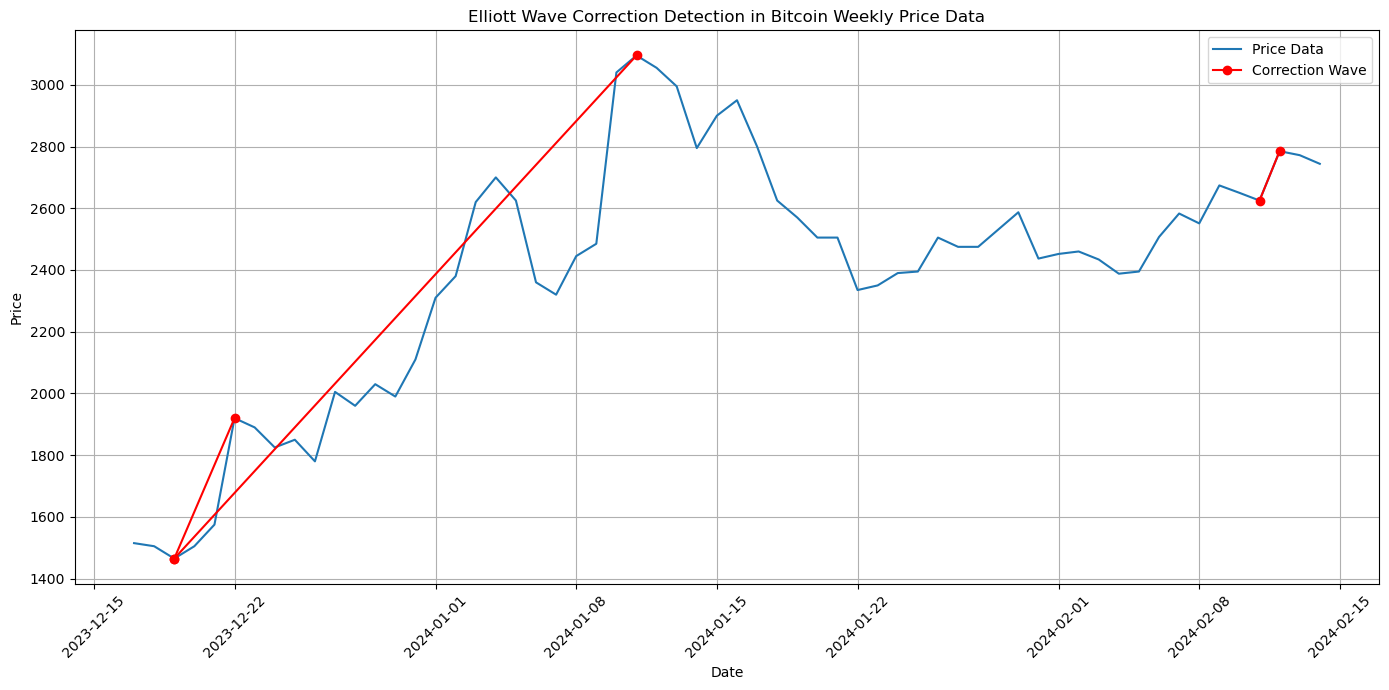

Predicted next wave at index 58 with price 1313.333333333334


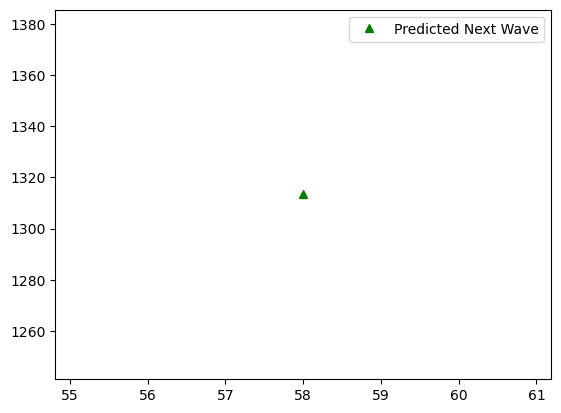

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression

def fetch_upbit_daily_data(market_code='KRW-ARB', count=60):
    """
    Fetches daily trading data from Upbit for a specified market.
    """
    url = "https://api.upbit.com/v1/candles/days"
    params = {"market": market_code, "count": str(count)}
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if not data:
            raise ValueError("No data returned from API")
        df = pd.DataFrame(data)
        df['timestamp'] = pd.to_datetime(df['candle_date_time_utc']).dt.date
        df = df[['timestamp', 'opening_price', 'high_price', 'low_price', 'trade_price']].copy()
        df.columns = ['Date', 'Open', 'High', 'Low', 'Close']
        df.set_index('Date', inplace=True)
        return df.sort_index(ascending=False)
    except requests.RequestException as e:
        print(f"API request error: {e}")
    except ValueError as e:
        print(f"Data processing error: {e}")
    return pd.DataFrame()

def predict_next_wave(correction_waves, price_data):
    """
    Predicts the next wave using Linear Regression based on the last correction wave.
    """
    if correction_waves:
        last_wave = correction_waves[-1]
        X = np.array([last_wave[0], last_wave[1]]).reshape(-1, 1)
        y = price_data.iloc[[last_wave[0], last_wave[1]]].values
        model = LinearRegression().fit(X, y)
        next_point = np.array([[last_wave[1] + 1]])
        predicted_price = model.predict(next_point)[0]
        return last_wave[1] + 1, predicted_price
    return None, None

# Modified main code to include daily data fetching and wave prediction
if __name__ == "__main__":
    btc_daily_data = fetch_upbit_daily_data()
    if not btc_daily_data.empty:
        preprocessed_data = btc_daily_data['Close']
        peaks, troughs = find_peaks_and_troughs(preprocessed_data)
        correction_waves = identify_correction_waves(preprocessed_data, peaks, troughs)
        plot_correction_waves(preprocessed_data, correction_waves)
        
        # Predict the next wave
        next_index, predicted_price = predict_next_wave(correction_waves, preprocessed_data)
        if next_index is not None:
            print(f"Predicted next wave at index {next_index} with price {predicted_price}")
            plt.plot(next_index, predicted_price, 'g^', label='Predicted Next Wave')
            plt.legend()
            plt.show()
    else:
        print("Unable to fetch or process data.")


In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyupbit

# Fetching and Preprocessing Data
def get_bitcoin_data_60_days():
    df = pyupbit.get_ohlcv("KRW-ARB", interval="day", count=60)
    return df[['close']]  # Assuming we're only interested in the closing prices for simplicity

df = get_bitcoin_data_60_days()

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df.values)

# StockDataset definition
class StockDataset(Dataset):
    def __init__(self, data, input_window, output_window, stride):
        self.input_window = input_window
        self.output_window = output_window
        self.stride = stride

        self.X = []
        self.y = []
        start = 0
        while start + input_window + output_window <= len(data):
            self.X.append(data[start:start+input_window])
            self.y.append(data[start+input_window:start+input_window+output_window])
            start += stride

        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.y[idx]).float()

# Defining the Transformer Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_window, output_window, feature_size, num_layers, num_heads):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, 1)
        self.init_weights()
        self.input_window = input_window
        self.output_window = output_window
        self.feature_size = feature_size

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        if self.src_mask is None or self.src_mask.size(0) != len(x):
            mask = self._generate_square_subsequent_mask(len(x)).to(x.device)
            self.src_mask = mask

        x = x * math.sqrt(self.feature_size)
        x = self.pos_encoder(x)
        output = self.transformer_encoder(x, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

# Data Preparation
input_window = 30
output_window = 1
stride = 1
dataset = StockDataset(df_scaled, input_window, output_window, stride)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Model Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_window, output_window, feature_size=16, num_layers=4, num_heads=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# Training Loop
model.train()
epochs = 10000
for epoch in range(epochs):
    total_loss = 0
    for x, y in loader:
        x = x.transpose(0, 1).to(device)
        y = y.transpose(0, 1).to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss / len(loader)}')

# Prediction (Simplified Example)
model.eval()
with torch.no_grad():
    recent_data = df_scaled[-input_window:].reshape(1, input_window, 1)
    recent_data_tensor = torch.from_numpy(recent_data).float().to(device)
    recent_data_tensor = recent_data_tensor.transpose(0, 1)  # Adjust shape for model input
    predicted = model(recent_data_tensor)
    predicted = predicted.view(-1).cpu().numpy()
    predicted_price = scaler.inverse_transform(predicted.reshape(-1, 1))
    print(f"Predicted Price: {predicted_price[-1][0]}")


C:\Users\ether\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\ether\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 30, 1])) that is different to the input size (torch.Size([30, 30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.6462979912757874
Epoch 10, Loss: 0.009735800325870514
Epoch 20, Loss: 0.008763839490711689
Epoch 30, Loss: 0.00882168859243393
Epoch 40, Loss: 0.008648130111396313
Epoch 50, Loss: 0.008656823076307774
Epoch 60, Loss: 0.008486367762088776
Epoch 70, Loss: 0.00860830582678318
Epoch 80, Loss: 0.008504985831677914
Epoch 90, Loss: 0.00854010134935379
Epoch 100, Loss: 0.00871879979968071
Epoch 110, Loss: 0.008322545327246189
Epoch 120, Loss: 0.008303120732307434
Epoch 130, Loss: 0.008448011241853237
Epoch 140, Loss: 0.008450934663414955
Epoch 150, Loss: 0.008218360133469105
Epoch 160, Loss: 0.008290942758321762
Epoch 170, Loss: 0.00837971456348896
Epoch 180, Loss: 0.008241952396929264
Epoch 190, Loss: 0.008311168290674686
Epoch 200, Loss: 0.008193355984985828
Epoch 210, Loss: 0.008303855545818806
Epoch 220, Loss: 0.008296359330415726
Epoch 230, Loss: 0.008334694430232048
Epoch 240, Loss: 0.008319292217493057
Epoch 250, Loss: 0.008243215270340443
Epoch 260, Loss: 0.00832444336

Epoch 2120, Loss: 0.0021094386465847492
Epoch 2130, Loss: 0.002039079088717699
Epoch 2140, Loss: 0.0023142502177506685
Epoch 2150, Loss: 0.002744966186583042
Epoch 2160, Loss: 0.0018299672519788146
Epoch 2170, Loss: 0.0025509437546133995
Epoch 2180, Loss: 0.0022211147006601095
Epoch 2190, Loss: 0.0022840716410428286
Epoch 2200, Loss: 0.002441087504848838
Epoch 2210, Loss: 0.0020671256352216005
Epoch 2220, Loss: 0.0032515665516257286
Epoch 2230, Loss: 0.0017231478122994304
Epoch 2240, Loss: 0.0032458272762596607
Epoch 2250, Loss: 0.002617522841319442
Epoch 2260, Loss: 0.0025559847708791494
Epoch 2270, Loss: 0.0023928838782012463
Epoch 2280, Loss: 0.0018190164119005203
Epoch 2290, Loss: 0.0019722008146345615
Epoch 2300, Loss: 0.002566042821854353
Epoch 2310, Loss: 0.001702511915937066
Epoch 2320, Loss: 0.002146161627024412
Epoch 2330, Loss: 0.002092240611091256
Epoch 2340, Loss: 0.0024377917870879173
Epoch 2350, Loss: 0.002313562436029315
Epoch 2360, Loss: 0.00207020272500813
Epoch 2370,

Epoch 4190, Loss: 0.0020999109838157892
Epoch 4200, Loss: 0.0017028899164870381
Epoch 4210, Loss: 0.0015208674594759941
Epoch 4220, Loss: 0.0021858750842511654
Epoch 4230, Loss: 0.0015420536510646343
Epoch 4240, Loss: 0.0020449920557439327
Epoch 4250, Loss: 0.001691741170361638
Epoch 4260, Loss: 0.0022520434577018023
Epoch 4270, Loss: 0.00153604696970433
Epoch 4280, Loss: 0.0015342198312282562
Epoch 4290, Loss: 0.0012316986685618758
Epoch 4300, Loss: 0.0015019632410258055
Epoch 4310, Loss: 0.002051173010841012
Epoch 4320, Loss: 0.0014877476496621966
Epoch 4330, Loss: 0.0015819554682821035
Epoch 4340, Loss: 0.0012870790669694543
Epoch 4350, Loss: 0.001590416650287807
Epoch 4360, Loss: 0.0010935569880530238
Epoch 4370, Loss: 0.002050605369731784
Epoch 4380, Loss: 0.0018769935704767704
Epoch 4390, Loss: 0.0017720175674185157
Epoch 4400, Loss: 0.0026529342867434025
Epoch 4410, Loss: 0.0014993550721555948
Epoch 4420, Loss: 0.0014651764649897814
Epoch 4430, Loss: 0.0011316625168547034
Epoch 

Epoch 6260, Loss: 0.0012058087158948183
Epoch 6270, Loss: 0.0012346483999863267
Epoch 6280, Loss: 0.0016586676938459277
Epoch 6290, Loss: 0.001378905726596713
Epoch 6300, Loss: 0.001070445287041366
Epoch 6310, Loss: 0.0013263357104733586
Epoch 6320, Loss: 0.0015474503161385655
Epoch 6330, Loss: 0.0013740735594183207
Epoch 6340, Loss: 0.0011932061752304435
Epoch 6350, Loss: 0.0014058892847970128
Epoch 6360, Loss: 0.00154805276542902
Epoch 6370, Loss: 0.0012828237377107143
Epoch 6380, Loss: 0.0012263678945600986
Epoch 6390, Loss: 0.0011785042006522417
Epoch 6400, Loss: 0.0012919530272483826
Epoch 6410, Loss: 0.0016104821115732193
Epoch 6420, Loss: 0.000992487883195281
Epoch 6430, Loss: 0.0011374081950634718
Epoch 6440, Loss: 0.0011810180731117725
Epoch 6450, Loss: 0.0015730434097349644
Epoch 6460, Loss: 0.0020500647369772196
Epoch 6470, Loss: 0.001357298344373703
Epoch 6480, Loss: 0.001355880405753851
Epoch 6490, Loss: 0.0013323029270395637
Epoch 6500, Loss: 0.0013106174301356077
Epoch 6

Epoch 8330, Loss: 0.0008693582494743168
Epoch 8340, Loss: 0.001261106226593256
Epoch 8350, Loss: 0.001043650321662426
Epoch 8360, Loss: 0.000925148488022387
Epoch 8370, Loss: 0.0009976628934964538
Epoch 8380, Loss: 0.001290230662561953
Epoch 8390, Loss: 0.0014827742706984282
Epoch 8400, Loss: 0.0011798692867159843
Epoch 8410, Loss: 0.0011633940739557147
Epoch 8420, Loss: 0.00079418218228966
Epoch 8430, Loss: 0.0012665807735174894
Epoch 8440, Loss: 0.000764007621910423
Epoch 8450, Loss: 0.0013016414595767856
Epoch 8460, Loss: 0.001295729773119092
Epoch 8470, Loss: 0.000842027657199651
Epoch 8480, Loss: 0.0009365248261019588
Epoch 8490, Loss: 0.0011483178241178393
Epoch 8500, Loss: 0.0008498840616084635
Epoch 8510, Loss: 0.0009947159560397267
Epoch 8520, Loss: 0.0007456006132997572
Epoch 8530, Loss: 0.000996817136183381
Epoch 8540, Loss: 0.0009936451679095626
Epoch 8550, Loss: 0.0008715699659660459
Epoch 8560, Loss: 0.0010744945611804724
Epoch 8570, Loss: 0.0012367645977064967
Epoch 8580

C:\Users\ether\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\ether\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 30, 1])) that is different to the input size (torch.Size([30, 30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 0.6255987286567688
Epoch 10, Loss: 0.10053645819425583
Epoch 20, Loss: 0.09793215990066528
Epoch 30, Loss: 0.09767009317874908
Epoch 40, Loss: 0.09614959359169006
Epoch 50, Loss: 0.09528129547834396
Epoch 60, Loss: 0.09823257476091385
Epoch 70, Loss: 0.0974363163113594
Epoch 80, Loss: 0.09639674425125122
Epoch 90, Loss: 0.09702333807945251
Epoch 100, Loss: 0.09718572348356247
Epoch 110, Loss: 0.09656873345375061
Epoch 120, Loss: 0.09573888033628464
Epoch 130, Loss: 0.09549395740032196
Epoch 140, Loss: 0.09641885757446289
Epoch 150, Loss: 0.09655951708555222
Epoch 160, Loss: 0.09669748693704605
Epoch 170, Loss: 0.09662685543298721
Epoch 180, Loss: 0.09621455520391464
Epoch 190, Loss: 0.09638024121522903
Epoch 200, Loss: 0.09635086357593536
Epoch 210, Loss: 0.09586574882268906
Epoch 220, Loss: 0.09574082493782043
Epoch 230, Loss: 0.09597145766019821
Epoch 240, Loss: 0.09241185337305069
Epoch 250, Loss: 0.05354788154363632
Epoch 260, Loss: 0.030357535928487778
Epoch 270, Lo

Epoch 2150, Loss: 0.012912539765238762
Epoch 2160, Loss: 0.006836587563157082
Epoch 2170, Loss: 0.010356537066400051
Epoch 2180, Loss: 0.00967314187437296
Epoch 2190, Loss: 0.007920341566205025
Epoch 2200, Loss: 0.009588315151631832
Epoch 2210, Loss: 0.0071986219845712185
Epoch 2220, Loss: 0.0054036700166761875
Epoch 2230, Loss: 0.010111496783792973
Epoch 2240, Loss: 0.00956653244793415
Epoch 2250, Loss: 0.007913393899798393
Epoch 2260, Loss: 0.007980065420269966
Epoch 2270, Loss: 0.009715035557746887
Epoch 2280, Loss: 0.007915377616882324
Epoch 2290, Loss: 0.010038530454039574
Epoch 2300, Loss: 0.008403101935982704
Epoch 2310, Loss: 0.006619052030146122
Epoch 2320, Loss: 0.009971851482987404
Epoch 2330, Loss: 0.006430213339626789
Epoch 2340, Loss: 0.009771222248673439
Epoch 2350, Loss: 0.007789970375597477
Epoch 2360, Loss: 0.009178097359836102
Epoch 2370, Loss: 0.0071848235093057156
Epoch 2380, Loss: 0.0072290473617613316
Epoch 2390, Loss: 0.01011863723397255
Epoch 2400, Loss: 0.0070

Epoch 4260, Loss: 0.012190893292427063
Epoch 4270, Loss: 0.007217035628855228
Epoch 4280, Loss: 0.005012693349272013
Epoch 4290, Loss: 0.009559021331369877
Epoch 4300, Loss: 0.00888414029031992
Epoch 4310, Loss: 0.004754092078655958
Epoch 4320, Loss: 0.004569006152451038
Epoch 4330, Loss: 0.007629973813891411
Epoch 4340, Loss: 0.0054228343069553375
Epoch 4350, Loss: 0.006305944640189409
Epoch 4360, Loss: 0.006937981583178043
Epoch 4370, Loss: 0.007943226955831051
Epoch 4380, Loss: 0.0062077646143734455
Epoch 4390, Loss: 0.005449357908219099
Epoch 4400, Loss: 0.004652084782719612
Epoch 4410, Loss: 0.0067885383032262325
Epoch 4420, Loss: 0.004485317971557379
Epoch 4430, Loss: 0.005099216941744089
Epoch 4440, Loss: 0.0053168777376413345
Epoch 4450, Loss: 0.0055104466155171394
Epoch 4460, Loss: 0.006060845218598843
Epoch 4470, Loss: 0.004166451748460531
Epoch 4480, Loss: 0.005600431002676487
Epoch 4490, Loss: 0.005040748510509729
Epoch 4500, Loss: 0.003928817342966795
Epoch 4510, Loss: 0.0

Epoch 6360, Loss: 0.004136744420975447
Epoch 6370, Loss: 0.005750071257352829
Epoch 6380, Loss: 0.006670332048088312
Epoch 6390, Loss: 0.006304031703621149
Epoch 6400, Loss: 0.00630016578361392
Epoch 6410, Loss: 0.0049185664393007755
Epoch 6420, Loss: 0.005629826802760363
Epoch 6430, Loss: 0.004152684938162565
Epoch 6440, Loss: 0.007267377804964781
Epoch 6450, Loss: 0.003839863697066903
Epoch 6460, Loss: 0.004825762007385492
Epoch 6470, Loss: 0.002318235347047448
Epoch 6480, Loss: 0.005303942132741213
Epoch 6490, Loss: 0.0036390877794474363
Epoch 6500, Loss: 0.004447341896593571
Epoch 6510, Loss: 0.003963907714933157
Epoch 6520, Loss: 0.005195586476475
Epoch 6530, Loss: 0.004906963091343641
Epoch 6540, Loss: 0.0025642116088420153
Epoch 6550, Loss: 0.005816189106553793
Epoch 6560, Loss: 0.001958504319190979
Epoch 6570, Loss: 0.002964577404782176
Epoch 6580, Loss: 0.0035313370171934366
Epoch 6590, Loss: 0.005111949052661657
Epoch 6600, Loss: 0.005011924542486668
Epoch 6610, Loss: 0.00459

Epoch 8450, Loss: 0.002604775596410036
Epoch 8460, Loss: 0.0037199887447059155
Epoch 8470, Loss: 0.0027701242361217737
Epoch 8480, Loss: 0.006091324612498283
Epoch 8490, Loss: 0.004493447951972485
Epoch 8500, Loss: 0.003979422617703676
Epoch 8510, Loss: 0.008686588145792484
Epoch 8520, Loss: 0.0028822568710893393
Epoch 8530, Loss: 0.009442601352930069
Epoch 8540, Loss: 0.004624974448233843
Epoch 8550, Loss: 0.0029400514904409647
Epoch 8560, Loss: 0.0035394334699958563
Epoch 8570, Loss: 0.0077500613406300545
Epoch 8580, Loss: 0.0032784719951450825
Epoch 8590, Loss: 0.004739688243716955
Epoch 8600, Loss: 0.007152517791837454
Epoch 8610, Loss: 0.002657592296600342
Epoch 8620, Loss: 0.004353011958301067
Epoch 8630, Loss: 0.002556208986788988
Epoch 8640, Loss: 0.0034192532766610384
Epoch 8650, Loss: 0.006258459761738777
Epoch 8660, Loss: 0.003917651250958443
Epoch 8670, Loss: 0.002633117139339447
Epoch 8680, Loss: 0.0022383646573871374
Epoch 8690, Loss: 0.0035707554779946804
Epoch 8700, Los

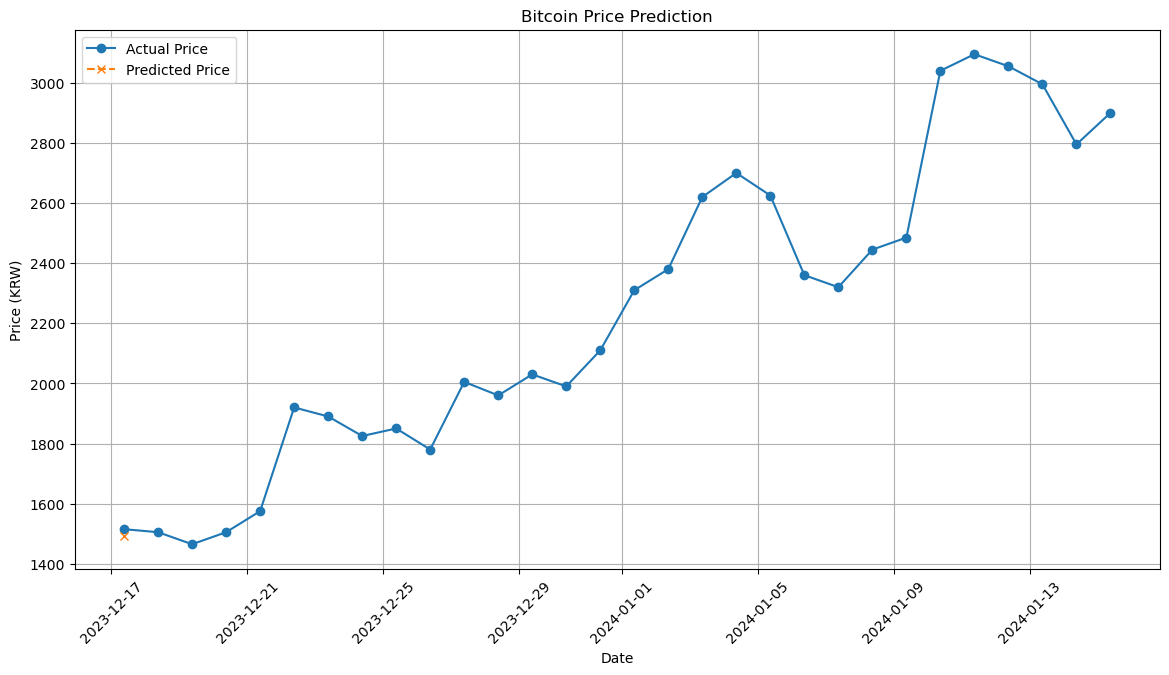

In [5]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import requests

# 데이터 로딩 함수
def get_bitcoin_data_60_days():
    url = "https://api.upbit.com/v1/candles/days"
    querystring = {"market":"KRW-ARB","count":"60"}
    response = requests.get(url, params=querystring)
    data = response.json()
    df = pd.DataFrame(data)[['candle_date_time_kst', 'trade_price']]
    df.columns = ['DateTime', 'Close']
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df.set_index('DateTime', inplace=True)
    return df

# 데이터 전처리
df = get_bitcoin_data_60_days()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df['Close'].values.reshape(-1,1))

class StockDataset(Dataset):
    def __init__(self, data, input_window, output_window, stride):
        self.input_window = input_window
        self.output_window = output_window
        self.stride = stride
        self.data = data

        self.X = []
        self.y = []
        start = 0
        while start + input_window + output_window <= len(data):
            self.X.append(data[start:start+input_window])
            self.y.append(data[start+input_window:start+input_window+output_window])
            start += stride

        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]).float(), torch.from_numpy(self.y[idx]).float()

# Transformer 모델 정의
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self, input_window, output_window, feature_size, num_layers, num_heads):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size, 1)
        self.init_weights()
        self.input_window = input_window
        self.output_window = output_window
        self.feature_size = feature_size

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, x):
        x = x * math.sqrt(self.feature_size)
        x = self.pos_encoder(x)
        output = self.transformer_encoder(x)
        output = self.decoder(output)
        return output

# 데이터셋 및 데이터 로더 준비
input_window = 30
output_window = 1
stride = 1
dataset = StockDataset(df_scaled, input_window, output_window, stride)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# 모델 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerModel(input_window, output_window, feature_size=16, num_layers=4, num_heads=2).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

# 학습 루프
model.train()
epochs = 10000
for epoch in range(epochs):
    total_loss = 0
    for x, y in loader:
        x = x.transpose(0, 1).to(device)
        y = y.transpose(0, 1).to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {total_loss / len(loader)}')

# 예측 및 시각화
model.eval()
with torch.no_grad():
    recent_data_scaled = df_scaled[-input_window:]
    recent_data_tensor = torch.FloatTensor(recent_data_scaled).view(-1, input_window, 1).transpose(0, 1).to(device)
    predicted = model(recent_data_tensor).view(-1).cpu().numpy()
    predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))

plt.figure(figsize=(14, 7))
plt.plot(df.index[-input_window:], df['Close'][-input_window:], label='Actual Price', marker='o')
plt.plot(df.index[-output_window:], predicted_prices[-output_window:], label='Predicted Price', marker='x', linestyle='--')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (KRW)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()